# Setting up for modelling

In [ ]:
pip install scikit-learn


In [ ]:
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
import pandas as pd
import numpy as np

# Load cleaned data
df = pd.read_csv("df_option2_cleaned.csv")

# Quick checks
print("Shape:", df.shape)
print("\nColumn names:\n", df.columns.tolist())
df.head()

Shape: (44193, 45)

Column names:
 ['race', 'gender', 'age', 'time_in_hospital', 'payer_code', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'target_option2', 'weight_missing', 'admission_type_grouped', 'discharge_group', 'admission_source_grouped', 'diag_1_group', 'diag_2_group', 'diag_3_group', 'medical_specialty_grouped']


,race,gender,age,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,diabetesMed,target_option2,weight_missing,admission_type_grouped,discharge_group,admission_source_grouped,diag_1_group,diag_2_group,diag_3_group,medical_specialty_grouped
0,Caucasian,Female,[0-10),1,Missing,41,0,1,0,0,...,No,No,0,Unknown,Unknown,Referral,Diabetes,Unknown,Unknown,Pediatrics
1,AfricanAmerican,Female,[20-30),2,Missing,11,5,13,2,0,...,Yes,No,0,Emergency_Urgent,Home,Emergency,Other,Diabetes,Other_V,Unknown
2,Caucasian,Male,[30-40),2,Missing,44,1,16,0,0,...,Yes,No,0,Emergency_Urgent,Home,Emergency,Infectious,Diabetes,Circulatory,Unknown
3,Caucasian,Male,[40-50),1,Missing,51,0,8,0,0,...,Yes,No,0,Emergency_Urgent,Home,Emergency,Neoplasms,Neoplasms,Diabetes,Unknown
4,Caucasian,Male,[60-70),4,Missing,70,1,21,0,0,...,Yes,No,0,Elective,Home,Referral,Circulatory,Circulatory,Other_V,Unknown


In [ ]:
# Check missing values column-wise
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


,0
max_glu_serum,41037
A1Cresult,37162
medical_specialty_grouped,1


In [ ]:
print("A1Cresult values:", df['A1Cresult'].unique())
print("max_glu_serum values:", df['max_glu_serum'].unique())


A1Cresult values: [nan '>7' '>8' 'Norm']
max_glu_serum values: [nan '>300' 'Norm' '>200']


In [ ]:
df['A1Cresult'] = df['A1Cresult'].fillna('None')
df['max_glu_serum'] = df['max_glu_serum'].fillna('None')



In [ ]:
unique_values = {col: df[col].unique() for col in df.columns}

In [ ]:
# To display them neatly:
for col, values in unique_values.items():
    print(f"Column: {col}")
    print(f"Unique values: {values}")
    print("-" * 50)

Column: race
Unique values: ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
--------------------------------------------------
Column: gender
Unique values: ['Female' 'Male' 'Unknown/Invalid']
--------------------------------------------------
Column: age
Unique values: ['[0-10)' '[20-30)' '[30-40)' '[40-50)' '[60-70)' '[80-90)' '[90-100)'
 '[50-60)' '[70-80)' '[10-20)']
--------------------------------------------------
Column: time_in_hospital
Unique values: [ 1  2  4 13 12  7 10  3  6  5  9 11 14  8]
--------------------------------------------------
Column: payer_code
Unique values: ['Missing' 'MC' 'MD' 'UN' 'SP' 'CP' 'HM' 'BC' 'SI' 'DM' 'CM' 'PO' 'WC'
 'CH' 'OT' 'OG' 'MP']
--------------------------------------------------
Column: num_lab_procedures
Unique values: [ 41  11  44  51  70  68  33  62  60  55  75  45  29  42  66  36  47  19
  64  87  46  72  10  25   2  65  67  40  54  58  57  32  28  35  52  59
  53  56  73  22  31  96  39  78  48  61  34  43   1  18  82  3

**Previously I imputed missing values, but didn't add missing indicator variable, so adding them now**

In [ ]:
# Create missing indicators for each relevant column
df['payer_code_missing'] = df['payer_code'].apply(lambda x: 1 if x == 'Missing' else 0)
df['medical_specialty_missing'] = df['medical_specialty_grouped'].apply(lambda x: 1 if x == 'Missing' else 0)
df['diag_1_missing'] = df['diag_1_group'].apply(lambda x: 1 if x == 'Unknown' else 0)
df['diag_2_missing'] = df['diag_2_group'].apply(lambda x: 1 if x == 'Unknown' else 0)
df['diag_3_missing'] = df['diag_3_group'].apply(lambda x: 1 if x == 'Unknown' else 0)


In [ ]:
#Target column

df['target'] = df['target_option2'].map({'No': 0, 'Yes': 1})
df.drop(columns=['target_option2'], inplace=True)


In [ ]:
# Convert age bins to midpoints
age_mid_map = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df['age_numeric'] = df['age'].map(age_mid_map)


In [ ]:
df['age_numeric'] = df['age'].map(age_mid_map).astype(int)


## Creating Interaction Features

In [ ]:
# 1. Stay × Medications
df['stay_medication_load'] = df['time_in_hospital'] * df['num_medications']

# 2. Inpatient × Emergency visits
df['acute_instability'] = df['number_inpatient'] * df['number_emergency']

# 3. Age × Diagnoses
df['age_num_diagnoses'] = df['age_numeric'] * df['number_diagnoses']

# 4. Procedures × Stay
df['proc_stay_intensity'] = df['num_procedures'] * df['time_in_hospital']


In [ ]:
df.dtypes

,0
race,object
gender,object
age,object
time_in_hospital,int64
payer_code,object
num_lab_procedures,int64
num_procedures,int64
num_medications,int64
number_outpatient,int64
number_emergency,int64


In [ ]:
#Dropping Age as I created new age column as numeric

df.drop(columns=['age'], errors='ignore', inplace=True)

In [ ]:
# Target distribution
y = df['target']
print("Class Distribution:")
print(y.value_counts(normalize=True).rename_axis('Class').reset_index(name='Proportion'))
print("\nRaw Counts:")
print(y.value_counts())


Class Distribution:
   Class  Proportion
0      0    0.822936
1      1    0.177064

Raw Counts:
target
0    36368
1     7825
Name: count, dtype: int64


In [ ]:
# Separate target
y = df['target']
X = df.drop(columns=['target'])

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Show shape
print("Shape after encoding:", X_encoded.shape)


Shape after encoding: (44193, 167)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, stratify=y, random_state=1
)

# Confirm class distribution
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))


Training class distribution:
 target
0    0.822951
1    0.177049
Name: proportion, dtype: float64
Test class distribution:
 target
0    0.822899
1    0.177101
Name: proportion, dtype: float64


## Balancing Methods

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Apply undersampling only on training set
rus = RandomUnderSampler(random_state=1)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print("After Undersampling (train):")
print(y_train_rus.value_counts())


After Undersampling (train):
target
0    5477
1    5477
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Apply random oversampling on training data
ros = RandomOverSampler(random_state=1)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print("After Oversampling (train):")
print(y_train_ros.value_counts())


After Oversampling (train):
target
1    25458
0    25458
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE (train):")
print(y_train_smote.value_counts())


After SMOTE (train):
target
1    25458
0    25458
Name: count, dtype: int64


In [ ]:
# Initialize results list
model_results = []


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

def evaluate_decision_tree(X_train, y_train, X_test, y_test, balancing_method):
    model = DecisionTreeClassifier(max_depth=5, random_state=1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Print results
    print(f"\n===== Decision Tree with {balancing_method} =====")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("ROC AUC Score:", auc)

    # Save to global results list
    model_results.append({
        'model_type': 'Decision Tree',
        'balancing_method': balancing_method,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': auc
    })


In [ ]:
evaluate_decision_tree(X_train_rus, y_train_rus, X_test, y_test, "Random Undersampling")
evaluate_decision_tree(X_train_ros, y_train_ros, X_test, y_test, "Random Oversampling")
evaluate_decision_tree(X_train_smote, y_train_smote, X_test, y_test, "SMOTE")



===== Decision Tree with Random Undersampling =====
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.59      0.71     10910
           1       0.26      0.68      0.38      2348

    accuracy                           0.61     13258
   macro avg       0.58      0.64      0.55     13258
weighted avg       0.78      0.61      0.65     13258

Confusion Matrix:
[[6449 4461]
 [ 743 1605]]
ROC AUC Score: 0.6876640532652945

===== Decision Tree with Random Oversampling =====
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.59      0.71     10910
           1       0.26      0.68      0.38      2348

    accuracy                           0.60     13258
   macro avg       0.58      0.63      0.54     13258
weighted avg       0.78      0.60      0.65     13258

Confusion Matrix:
[[6431 4479]
 [ 759 1589]]
ROC AUC Score: 0.6880291278963551

===== Decision Tree with SMOTE =====

In [ ]:
import pandas as pd
results_df = pd.DataFrame(model_results)
display(results_df.sort_values(by='roc_auc', ascending=False))


,model_type,balancing_method,accuracy,precision,recall,f1_score,roc_auc
1,Decision Tree,Random Oversampling,0.604918,0.261866,0.676746,0.377614,0.688029
0,Decision Tree,Random Undersampling,0.607482,0.264590,0.683560,0.381507,0.687664
2,Decision Tree,SMOTE,0.747021,0.242051,0.201022,0.219637,0.627170


**Hypertuning**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}


grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=1),
    param_grid=param_grid,
    scoring={'recall': 'recall', 'roc_auc': 'roc_auc'},
    refit='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)


# Fit on oversampled training set
grid.fit(X_train_ros, y_train_ros)

# Best estimator
best_tree = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# Predict and evaluate
y_pred = best_tree.predict(X_test)
y_prob = best_tree.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# Show metrics
print("\n===== Tuned Decision Tree (Random Oversampling) =====")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", auc)

# Save results
model_results.append({
    'model_type': 'Decision Tree (Tuned)',
    'balancing_method': 'Random Oversampling',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'roc_auc': auc
})



===== Tuned Decision Tree (Random Oversampling) =====
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     10910
           1       0.27      0.29      0.28      2348

    accuracy                           0.74     13258
   macro avg       0.56      0.56      0.56     13258
weighted avg       0.74      0.74      0.74     13258

Confusion Matrix:
[[9103 1807]
 [1667  681]]
ROC AUC Score: 0.5622031036028088


In [ ]:
results_df = pd.DataFrame(model_results)
display(results_df.sort_values(by='roc_auc', ascending=False))


,model_type,balancing_method,accuracy,precision,recall,f1_score,roc_auc
1,Decision Tree,Random Oversampling,0.604918,0.261866,0.676746,0.377614,0.688029
0,Decision Tree,Random Undersampling,0.607482,0.264590,0.683560,0.381507,0.687664
2,Decision Tree,SMOTE,0.747021,0.242051,0.201022,0.219637,0.627170
3,Decision Tree (Tuned),Random Oversampling,0.737970,0.273714,0.290034,0.281638,0.562203


In [ ]:
model = DecisionTreeClassifier(max_depth=5, random_state=1)
model.fit(X_train_ros, y_train_ros)


DecisionTreeClassifier(max_depth=5, random_state=1)

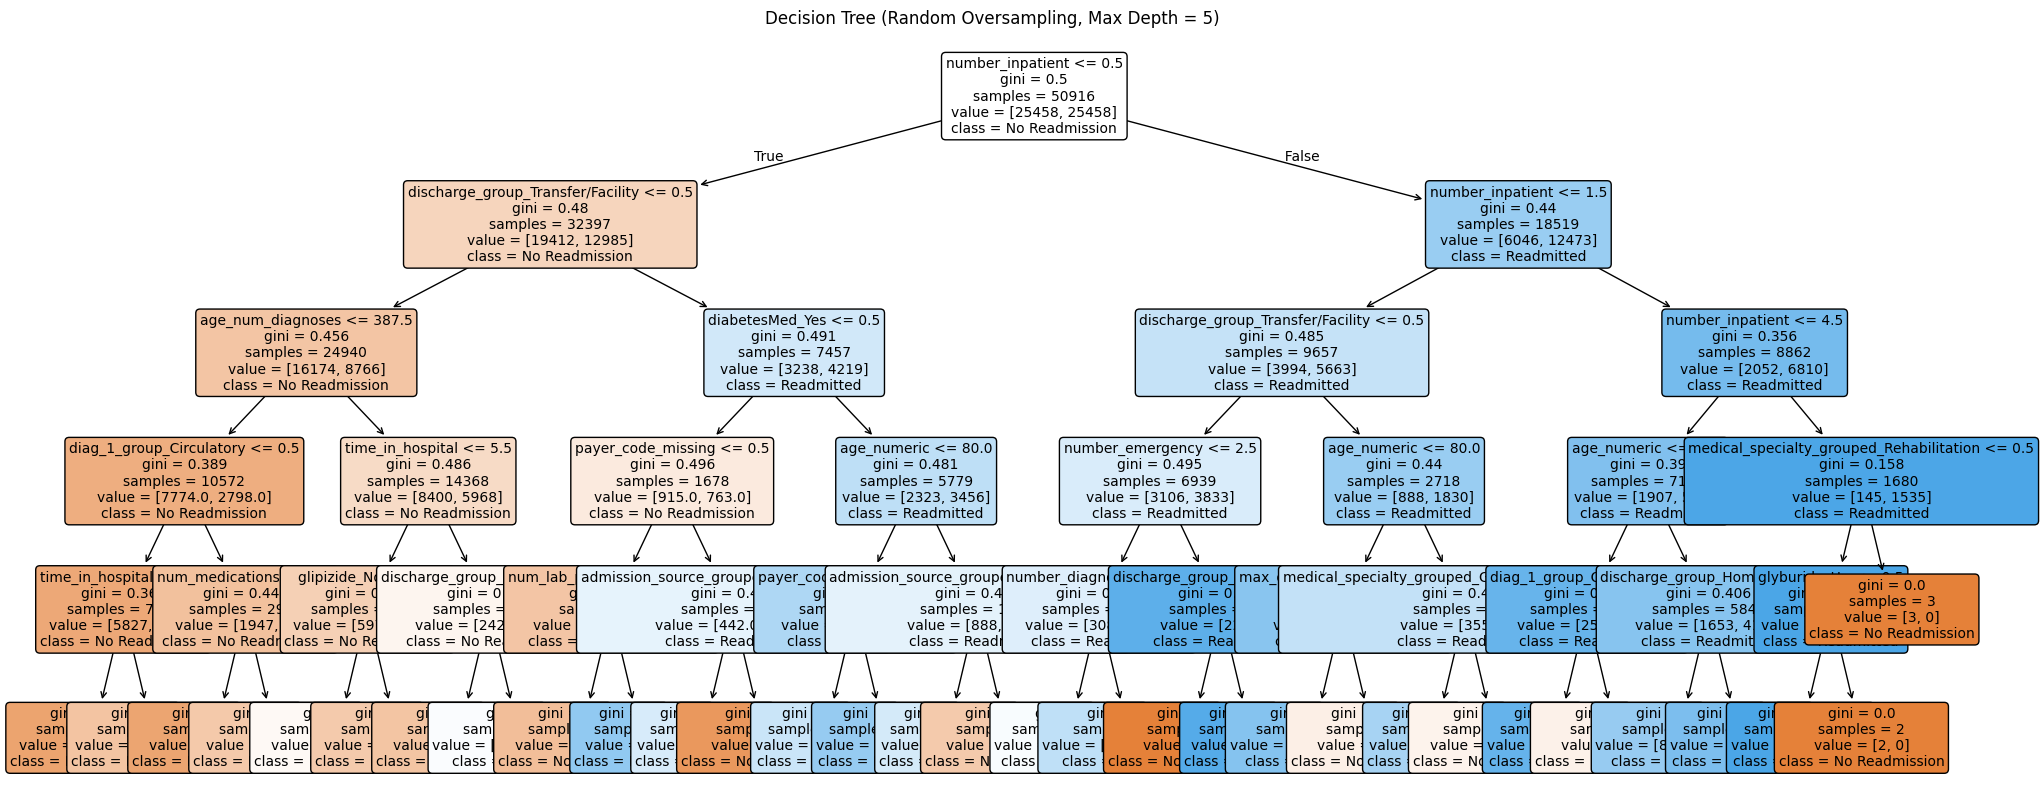

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Fit again to make sure
model = DecisionTreeClassifier(max_depth=5, random_state=1)
model.fit(X_train_ros, y_train_ros)

# Plot
plt.figure(figsize=(24, 10))
plot_tree(
    model,
    feature_names=X_train_ros.columns,
    class_names=['No Readmission', 'Readmitted'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree (Random Oversampling, Max Depth = 5)")
plt.show()


In [ ]:
!pip install shap


shap_values shape: (13258, 167, 2)
X_test shape: (13258, 167)


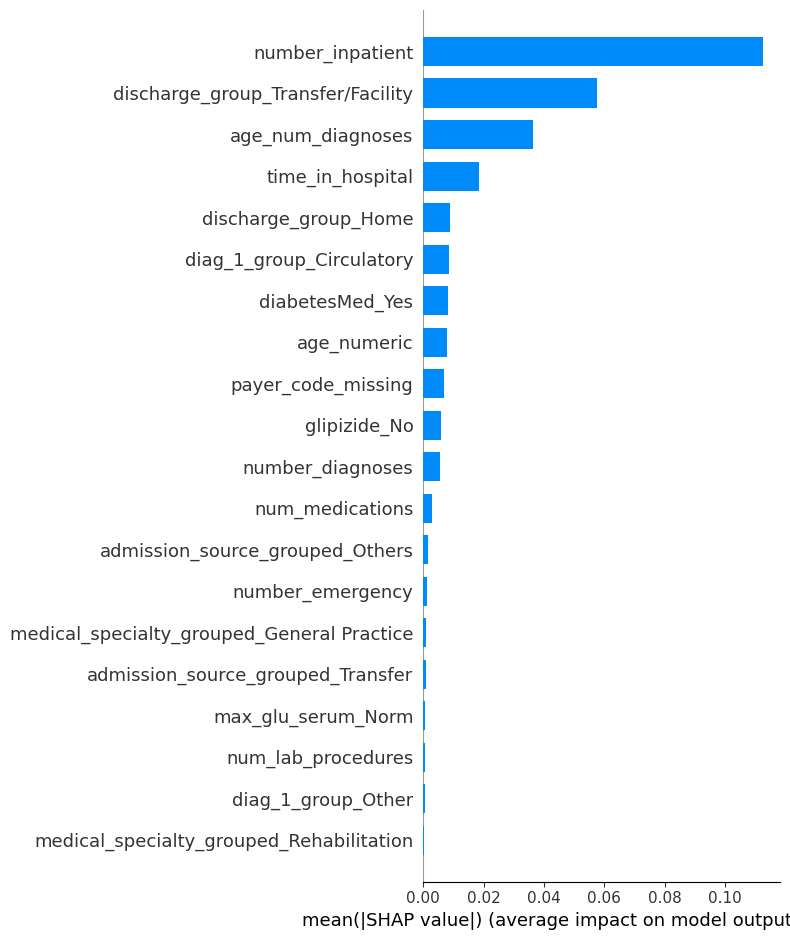

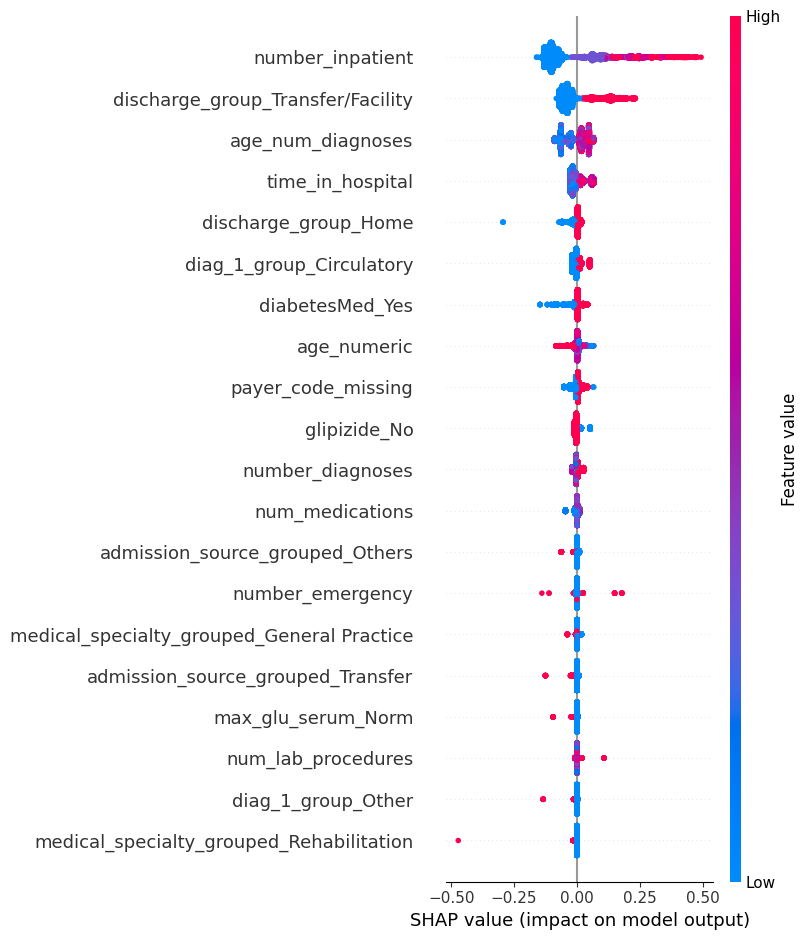

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt


# Convert X_test to NumPy array
X_test_array = X_test.to_numpy()
feature_names = X_test.columns.tolist()

# Create SHAP explainer for tree-based model
explainer = shap.TreeExplainer(model)

# Get SHAP values (shape: [samples, features, classes])
shap_values = explainer.shap_values(X_test_array)

# Check shape (for debugging)
print("shap_values shape:", np.array(shap_values).shape)
print("X_test shape:", X_test_array.shape)

# Extract SHAP values for class 1 (readmitted)
shap_class1 = shap_values[:, :, 1]

# Plot global feature importance (bar)
shap.summary_plot(shap_class1, X_test_array, feature_names=feature_names, plot_type='bar')

# Plot detailed impact per feature per sample (beeswarm)
shap.summary_plot(shap_class1, X_test_array, feature_names=feature_names)


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix
)

def evaluate_random_forest(X_train, y_train, X_test, y_test, balancing_method):
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight=None,
        random_state=1,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n===== Random Forest with {balancing_method} =====")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("ROC AUC Score:", auc)

    # Save to results
    model_results.append({
        'model_type': 'Random Forest',
        'balancing_method': balancing_method,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': auc
    })

    return model


In [ ]:
rf_rus = evaluate_random_forest(X_train_rus, y_train_rus, X_test, y_test, "Random Undersampling")
rf_ros = evaluate_random_forest(X_train_ros, y_train_ros, X_test, y_test, "Random Oversampling")
rf_smote = evaluate_random_forest(X_train_smote, y_train_smote, X_test, y_test, "SMOTE")



===== Random Forest with Random Undersampling =====
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.77     10910
           1       0.29      0.63      0.40      2348

    accuracy                           0.66     13258
   macro avg       0.59      0.65      0.58     13258
weighted avg       0.79      0.66      0.70     13258

Confusion Matrix:
[[7303 3607]
 [ 875 1473]]
ROC AUC Score: 0.7102597799558725

===== Random Forest with Random Oversampling =====
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90     10910
           1       0.54      0.12      0.19      2348

    accuracy                           0.83     13258
   macro avg       0.69      0.55      0.55     13258
weighted avg       0.78      0.83      0.78     13258

Confusion Matrix:
[[10672   238]
 [ 2070   278]]
ROC AUC Score: 0.7051229706581804

===== Random Forest with SMOTE =

In [ ]:
results_df = pd.DataFrame(model_results)
display(results_df.sort_values(by='roc_auc', ascending=False))


,model_type,balancing_method,accuracy,precision,recall,f1_score,roc_auc
4,Random Forest,Random Undersampling,0.661940,0.289961,0.627342,0.396607,0.710260
5,Random Forest,Random Oversampling,0.825916,0.538760,0.118399,0.194134,0.705123
1,Decision Tree,Random Oversampling,0.604918,0.261866,0.676746,0.377614,0.688029
0,Decision Tree,Random Undersampling,0.607482,0.264590,0.683560,0.381507,0.687664
6,Random Forest,SMOTE,0.822371,0.490141,0.074106,0.128746,0.671531
2,Decision Tree,SMOTE,0.747021,0.242051,0.201022,0.219637,0.627170
3,Decision Tree (Tuned),Random Oversampling,0.737970,0.273714,0.290034,0.281638,0.562203


**Balanced Random Forest**

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

def evaluate_balanced_random_forest(X_train, y_train, X_test, y_test, balancing_method='Internal Balanced RF'):
    model = BalancedRandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=1,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n===== Balanced Random Forest =====")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("ROC AUC Score:", auc)

    model_results.append({
        'model_type': 'Balanced Random Forest',
        'balancing_method': balancing_method,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': auc
    })

    return model


In [ ]:
brf_model = evaluate_balanced_random_forest(X_train, y_train, X_test, y_test)



===== Balanced Random Forest =====
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     10910
           1       0.36      0.45      0.40      2348

    accuracy                           0.76     13258
   macro avg       0.62      0.64      0.62     13258
weighted avg       0.78      0.76      0.77     13258

Confusion Matrix:
[[9032 1878]
 [1298 1050]]
ROC AUC Score: 0.7094611011262973


In [ ]:
results_df = pd.DataFrame(model_results)
display(results_df.sort_values(by='roc_auc', ascending=False))


,model_type,balancing_method,accuracy,precision,recall,f1_score,roc_auc
4,Random Forest,Random Undersampling,0.661940,0.289961,0.627342,0.396607,0.710260
7,Balanced Random Forest,Internal Balanced RF,0.760447,0.358607,0.447189,0.398029,0.709461
5,Random Forest,Random Oversampling,0.825916,0.538760,0.118399,0.194134,0.705123
1,Decision Tree,Random Oversampling,0.604918,0.261866,0.676746,0.377614,0.688029
0,Decision Tree,Random Undersampling,0.607482,0.264590,0.683560,0.381507,0.687664
6,Random Forest,SMOTE,0.822371,0.490141,0.074106,0.128746,0.671531
2,Decision Tree,SMOTE,0.747021,0.242051,0.201022,0.219637,0.627170
3,Decision Tree (Tuned),Random Oversampling,0.737970,0.273714,0.290034,0.281638,0.562203


**Hypertuning**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, roc_auc_score, classification_report
import numpy as np

# Define parameter grid for RandomizedSearch
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None,'balanced']
}

# Initialize RF
rf = RandomForestClassifier(random_state=1)

# Randomized Search with Recall and ROC AUC
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring={'recall': 'recall', 'roc_auc': 'roc_auc'},
    refit='recall',
    cv=5,
    verbose=2,
    random_state=1,
    n_jobs=-1
)

In [ ]:
rf_random.fit(X_train_ros, y_train_ros)

# Best model
best_rf = rf_random.best_estimator_
print("Best Parameters:", rf_random.best_params_)

# Evaluate on Test Data
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("Recall (Test):", recall_score(y_test, y_pred))
print("ROC AUC (Test):", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
Recall (Test): 0.14011925042589438
ROC AUC (Test): 0.7119658558408037

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90     10910
           1       0.53      0.14      0.22      2348

    accuracy                           0.83     13258
   macro avg       0.68      0.56      0.56     13258
weighted avg       0.78      0.83      0.78     13258



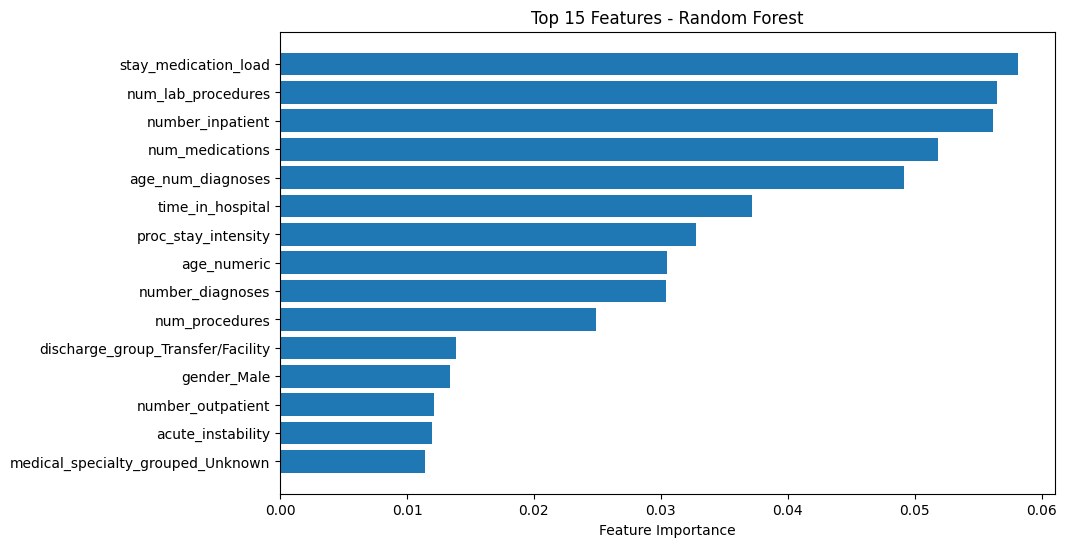

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature importance
importances = rf_rus.feature_importances_
features = X_train.columns

# Create dataframe
feat_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_importance_df['Feature'][:15], feat_importance_df['Importance'][:15])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 15 Features - Random Forest")
plt.show()


# Preparing for other models

## Removing insignificant variables

In [ ]:
# Preview data types
print(df.dtypes.value_counts())

# Select object-type columns (categorical)
cat_cols = df.select_dtypes(include='object').columns.tolist()

print("Categorical columns for chi-square:", cat_cols)


object    34
int64     20
Name: count, dtype: int64
Categorical columns for chi-square: ['race', 'gender', 'payer_code', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'admission_type_grouped', 'discharge_group', 'admission_source_grouped', 'diag_1_group', 'diag_2_group', 'diag_3_group', 'medical_specialty_grouped']


In [ ]:
# Make sure NaNs are replaced with string 'None'
df['A1Cresult'] = df['A1Cresult'].fillna('None')
df['max_glu_serum'] = df['max_glu_serum'].fillna('None')


In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include='object').columns.tolist()

df_chi = df.copy()
le = LabelEncoder()

for col in cat_cols:
    df_chi[col] = le.fit_transform(df_chi[col].astype(str))

In [ ]:
from sklearn.feature_selection import chi2

# Features and target
X_chi = df_chi[cat_cols]
y_chi = df_chi['target']

# Run chi-square
chi_scores, p_values = chi2(X_chi, y_chi)

# Combine results
chi_df = pd.DataFrame({
    'Feature': X_chi.columns,
    'Chi2': chi_scores,
    'p_value': p_values
}).sort_values(by='p_value')

# Show results
print("\nSignificant categorical features:")
print(chi_df[chi_df['p_value'] < 0.05])

print("\nInsignificant categorical features:")
print(chi_df[chi_df['p_value'] > 0.05])



Significant categorical features:
                      Feature        Chi2        p_value
28            discharge_group  945.195382  1.469439e-207
29   admission_source_grouped  198.181531   5.208005e-45
30               diag_1_group  114.332181   1.102095e-26
33  medical_specialty_grouped   72.750847   1.470951e-17
26                diabetesMed   35.944735   2.029942e-09
25                     change   29.088484   6.914680e-08
5                   metformin    8.238073   4.102067e-03
27     admission_type_grouped    5.347535   2.075158e-02

Insignificant categorical features:
                Feature          Chi2   p_value
20              insulin  1.165018e+00  0.280427
1                gender  1.132716e+00  0.287197
18           tolazamide  1.078562e+00  0.299019
12          tolbutamide  1.072142e+00  0.300462
32         diag_3_group  5.924977e-01  0.441455
2            payer_code  5.734094e-01  0.448907
4             A1Cresult  4.976310e-01  0.480543
16             miglitol  4.0757

In [ ]:
drop_cols = [
    'gender',
    'diag_2_group',
    'tolbutamide',
    'tolazamide',
    'A1Cresult',
    'max_glu_serum',
    'insulin',
    'metformin-rosiglitazone',
    'race',
    'repaglinide',
    'glipizide',
    'glyburide',
    'metformin-pioglitazone',
    'troglitazone',
    'glimepiride',
    'pioglitazone',
    'chlorpropamide',
    'rosiglitazone',
    'nateglinide',
    'glipizide-metformin',
    'miglitol',
    'acarbose',
    'glyburide-metformin'
]


In [ ]:
# Create new filtered DataFrame for modeling
drop_cols = [
    'gender', 'diag_2_group', 'tolbutamide', 'tolazamide', 'A1Cresult', 'max_glu_serum', 'insulin',
    'metformin-rosiglitazone', 'race', 'repaglinide', 'glipizide', 'glyburide',
    'metformin-pioglitazone', 'troglitazone', 'glimepiride', 'pioglitazone', 'chlorpropamide',
    'rosiglitazone', 'nateglinide', 'glipizide-metformin', 'miglitol', 'acarbose', 'glyburide-metformin'
]

df_filtered = df.copy()
df_filtered.drop(columns=drop_cols, inplace=True, errors='ignore')

print("Filtered DataFrame shape:", df_filtered.shape)


Filtered DataFrame shape: (44193, 31)


## Outliers Handling

In [ ]:
# Select only numeric columns
num_cols = df_filtered.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Exclude target column from outlier checks
num_cols = [col for col in num_cols if col != 'target']

print("Numeric columns to check:", num_cols)


Numeric columns to check: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'weight_missing', 'payer_code_missing', 'medical_specialty_missing', 'diag_1_missing', 'diag_2_missing', 'diag_3_missing', 'age_numeric', 'stay_medication_load', 'acute_instability', 'age_num_diagnoses', 'proc_stay_intensity']


In [ ]:
# Identify numeric columns
raw_num_cols = df_filtered.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Exclude target + binary columns
exclude_cols = ['target', 'insulin_binary', 'diabetesMed_binary', 'int_insulin_diabetesMed', 'weight_missing', 'payer_code_missing','medical_specialty_missing','diag_1_missing','diag_2_missing','diag_3_missing'  ]
num_cols = [col for col in raw_num_cols if col not in exclude_cols]

print("Final numeric columns to cap:", num_cols)


Final numeric columns to cap: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_numeric', 'stay_medication_load', 'acute_instability', 'age_num_diagnoses', 'proc_stay_intensity']


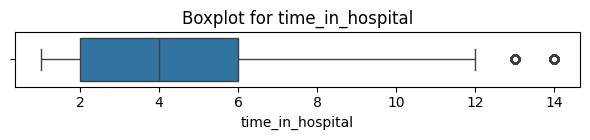

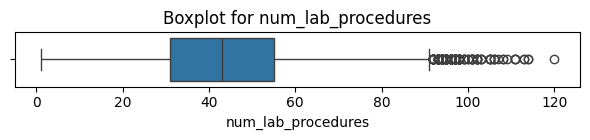

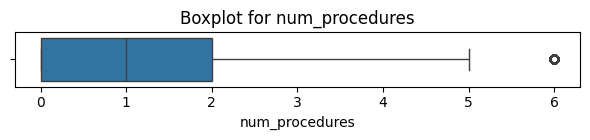

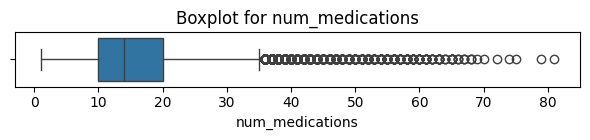

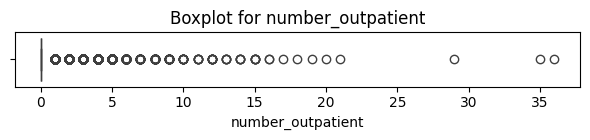

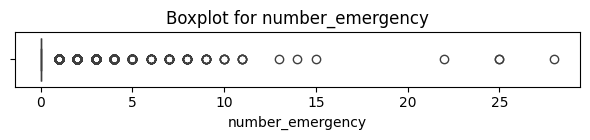

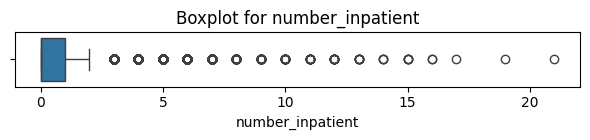

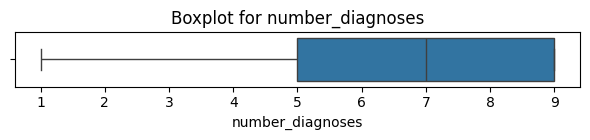

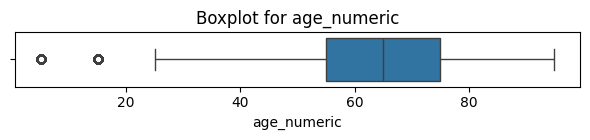

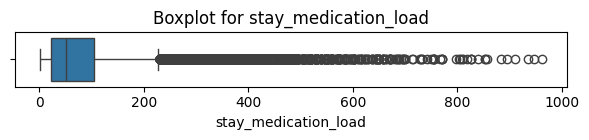

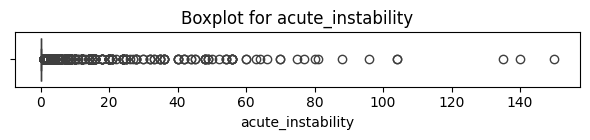

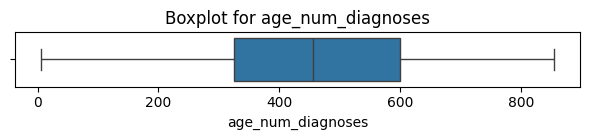

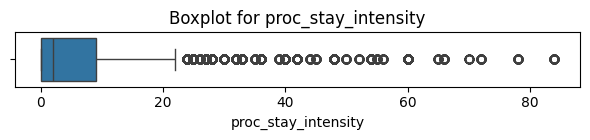

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot boxplots for each numeric column
for col in num_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df_filtered[col])
    plt.title(f"Boxplot for {col}")
    plt.tight_layout()
    plt.show()


In [ ]:
# Function to count outliers using IQR method
def count_outliers(df, columns):
    outlier_summary = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)][col].count()
        outlier_summary[col] = outliers
    return pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier_Count']).sort_values(by='Outlier_Count', ascending=False)

# Run it
outlier_counts = count_outliers(df_filtered, num_cols)
print(outlier_counts)


                      Outlier_Count
number_outpatient              5070
proc_stay_intensity            4263
number_emergency               3354
stay_medication_load           3240
number_inpatient               2299
num_procedures                 1961
acute_instability              1909
num_medications                1331
time_in_hospital               1070
age_numeric                     501
num_lab_procedures              168
number_diagnoses                  0
age_num_diagnoses                 0


## **Skewness check**

In [ ]:
# Define exclusion lists
exclude_cols = [
    'target',                                # Target variable
    'weight_missing', 'payer_code_missing',  # Missing indicators
    'medical_specialty_missing', 'diag_1_missing',
    'diag_2_missing', 'diag_3_missing',
    'stay_medication_load', 'acute_instability',  # Interaction features
    'age_num_diagnoses', 'proc_stay_intensity'
]

# Select numeric continuous features only
num_final = [
    col for col in df_filtered.select_dtypes(include=['int64', 'float64']).columns
    if col not in exclude_cols and df_filtered[col].nunique() > 2  # remove binary
]

print("Final numeric columns for skewness/outlier checks:\n", num_final)


Final numeric columns for skewness/outlier checks:
 ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_numeric']


In [ ]:
def count_outliers(df, columns):
    outlier_summary = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)][col].count()
        outlier_summary[col] = outliers
    return pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier_Count'])

# Run outlier detection
outlier_counts = count_outliers(df_filtered, num_final)
print(outlier_counts)


                    Outlier_Count
time_in_hospital             1070
num_lab_procedures            168
num_procedures               1961
num_medications              1331
number_outpatient            5070
number_emergency             3354
number_inpatient             2299
number_diagnoses                0
age_numeric                   501


In [ ]:
# Calculate skewness for numeric columns
skewness_df = df_filtered[num_final].skew().reset_index()
skewness_df.columns = ['Feature', 'Skewness']
skewness_df['Abs_Skew'] = skewness_df['Skewness'].abs()

print(skewness_df.sort_values(by='Abs_Skew', ascending=False))


              Feature   Skewness   Abs_Skew
5    number_emergency  13.624550  13.624550
4   number_outpatient   9.522075   9.522075
6    number_inpatient   4.181782   4.181782
3     num_medications   1.487550   1.487550
2      num_procedures   1.238729   1.238729
0    time_in_hospital   1.104160   1.104160
8         age_numeric  -0.640878   0.640878
7    number_diagnoses  -0.573577   0.573577
1  num_lab_procedures  -0.155854   0.155854


In [ ]:
# Merge outlier counts and skewness
final_check = outlier_counts.merge(skewness_df, left_index=True, right_on='Feature')


In [ ]:
# Apply log2 transform with +1 to handle zeros
df_filtered['number_emergency_log2'] = np.log2(df_filtered['number_emergency'] + 1)
df_filtered['number_outpatient_log2'] = np.log2(df_filtered['number_outpatient'] + 1)
df_filtered['number_inpatient_log2'] = np.log2(df_filtered['number_inpatient'] + 1)


In [ ]:
# Refresh numeric columns to include new log-transformed variables
num_updated = df_filtered.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Exclude target, binary, missing indicators, and interaction variables
exclude_cols_updated = [
    'target',
    'weight_missing', 'payer_code_missing', 'medical_specialty_missing',
    'diag_1_missing', 'diag_2_missing', 'diag_3_missing',
    'stay_medication_load', 'acute_instability',
    'age_num_diagnoses', 'proc_stay_intensity'
]

# Filter final numeric columns INCLUDING new transformed variables
num_final_updated = [
    col for col in num_updated
    if col not in exclude_cols_updated and df_filtered[col].nunique() > 2
]

print("Numeric columns for skewness (including transformed):\n", num_final_updated)


Numeric columns for skewness (including transformed):
 ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_numeric', 'number_emergency_log2', 'number_outpatient_log2', 'number_inpatient_log2']


In [ ]:
# Calculate skewness including new transformed variables
skewness_df = df_filtered[num_final_updated].skew().reset_index()
skewness_df.columns = ['Feature', 'Skewness']
skewness_df['Abs_Skew'] = skewness_df['Skewness'].abs()

# Sort and display
skewness_df = skewness_df.sort_values(by='Abs_Skew', ascending=False)
print("Skewness (Including New Variables):\n", skewness_df)


Skewness (Including New Variables):
                    Feature   Skewness   Abs_Skew
5         number_emergency  13.624550  13.624550
4        number_outpatient   9.522075   9.522075
9    number_emergency_log2   4.372060   4.372060
6         number_inpatient   4.181782   4.181782
10  number_outpatient_log2   3.389813   3.389813
11   number_inpatient_log2   1.724206   1.724206
3          num_medications   1.487550   1.487550
2           num_procedures   1.238729   1.238729
0         time_in_hospital   1.104160   1.104160
8              age_numeric  -0.640878   0.640878
7         number_diagnoses  -0.573577   0.573577
1       num_lab_procedures  -0.155854   0.155854


In [ ]:
# Re-check skewness for all numeric variables
skewness_df = df_filtered[num_final_updated].skew().reset_index()
skewness_df.columns = ['Feature', 'Skewness']
skewness_df['Abs_Skew'] = skewness_df['Skewness'].abs()

# Re-run outlier count on all numeric columns
outlier_counts = count_outliers(df_filtered, num_final_updated)

# Merge skewness and outlier counts
check_df = outlier_counts.merge(skewness_df, left_index=True, right_on='Feature')


print(check_df[['Feature', 'Outlier_Count', 'Skewness']])


                   Feature  Outlier_Count   Skewness
0         time_in_hospital           1070   1.104160
1       num_lab_procedures            168  -0.155854
2           num_procedures           1961   1.238729
3          num_medications           1331   1.487550
4        number_outpatient           5070   9.522075
5         number_emergency           3354  13.624550
6         number_inpatient           2299   4.181782
7         number_diagnoses              0  -0.573577
8              age_numeric            501  -0.640878
9    number_emergency_log2           3354   4.372060
10  number_outpatient_log2           5070   3.389813
11   number_inpatient_log2            660   1.724206


In [ ]:
# Variables to cap
to_cap = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_diagnoses',
    'age_numeric',
    'number_inpatient_log2'
]


In [ ]:
# Capping function
def cap_outliers(df, cols):
    capped_df = df.copy()
    for col in cols:
        Q1 = capped_df[col].quantile(0.25)
        Q3 = capped_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        capped_df[col] = np.where(
            capped_df[col] > upper, upper,
            np.where(capped_df[col] < lower, lower, capped_df[col])
        )
    return capped_df

# Apply capping
df_capped = cap_outliers(df_filtered, to_cap)


In [ ]:
# Drop redundant transformed columns
drop_cols = ['number_emergency_log2', 'number_outpatient_log2','number_inpatient']

df_capped.drop(columns=drop_cols, inplace=True, errors='ignore')



In [ ]:
# Re-check skewness
final_skewness = df_capped[to_cap].skew().reset_index()
final_skewness.columns = ['Feature', 'Final_Skewness']
print("\nSkewness after capping:\n", final_skewness)

# Re-check outlier counts
final_outliers = count_outliers(df_capped, to_cap)
print("\nOutlier counts after capping:\n", final_outliers)



Skewness after capping:
                  Feature  Final_Skewness
0       time_in_hospital        0.964492
1     num_lab_procedures       -0.184518
2         num_procedures        1.035720
3        num_medications        0.751311
4      number_outpatient        0.000000
5       number_emergency        0.000000
6       number_diagnoses       -0.573577
7            age_numeric       -0.481425
8  number_inpatient_log2        1.547059

Outlier counts after capping:
                        Outlier_Count
time_in_hospital                   0
num_lab_procedures                 0
num_procedures                     0
num_medications                    0
number_outpatient                  0
number_emergency                   0
number_diagnoses                   0
age_numeric                        0
number_inpatient_log2              0


I checked skewness for numeric variables and applied log2 transformation where needed. For number_emergency and number_outpatient, outliers remained same after transformation, so I kept their original variable for better interpretation For these variables and capped them. for variable where log2 reduced skew (like number_inpatient), I retained the transformed version and applied capping on this to handle outlier.

## Final preprocessing

In [ ]:
# Confirm 'target' is already binary
print("Unique values in df_filtered['target']:", df_filtered['target'].unique())


Unique values in df_filtered['target']: [0 1]


In [ ]:
# Full numeric columns
raw_num_cols = df_filtered.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Exclude binary/target variables
exclude_cols = ['target', 'insulin_binary', 'diabetesMed_binary', 'int_insulin_diabetesMed']
num_cols = [col for col in raw_num_cols if col not in exclude_cols]


In [ ]:
from sklearn.model_selection import train_test_split

X = df_capped.drop(columns=['target'])
y = df_capped['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1
)


In [ ]:
# One-hot encode
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


# Ada Boost

In [ ]:
!pip install imbalanced-learn


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier

# Resample training data using SMOTE
smote = SMOTE(random_state=1)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [ ]:
# Initialize AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=1)

# Fit
ada.fit(X_train_sm, y_train_sm)

# Predict
y_pred = ada.predict(X_test)
y_proba = ada.predict_proba(X_test)[:, 1]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("SMOTE + AdaBoost Results:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

model_results.append({
        'model_type': 'SMOTE + AdaBoost',
        'balancing_method': SMOTE,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': auc
    })



SMOTE + AdaBoost Results:
Accuracy: 0.7980087494343038
Precision: 0.381294964028777
Recall: 0.22572402044293016
F1 Score: 0.2835741037988229
ROC AUC: 0.6771147353989666


In [ ]:
import pandas as pd

ada_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': ada.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Top 20 features
ada_importance.head(20)


,Feature,Importance
19,number_inpatient_log2,0.129196
28,payer_code_Missing,0.094477
9,payer_code_missing,0.086921
49,discharge_group_Transfer/Facility,0.074848
44,discharge_group_Home,0.055609
50,discharge_group_Unknown,0.055391
36,metformin_No,0.050850
89,medical_specialty_grouped_Emergency/Trauma,0.047198
40,diabetesMed_Yes,0.032216
100,medical_specialty_grouped_Unknown,0.031262


# XG Boost

In [ ]:
!pip install imbalanced-learn


In [ ]:
!pip install xgboost


In [ ]:
from xgboost import XGBClassifier


In [ ]:
# Reset model_results for XGBoost runs only
model_results = [res for res in model_results if res['model_type'] != 'XGBoost']


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd

# Ensure model_results list exists
if 'model_results' not in globals():
    model_results = []

# Function to train XGBoost and return metrics
def run_xgboost_balancing(X_train, y_train, X_test, y_test, balancing_method):
    if balancing_method == "scale_pos_weight":
        neg, pos = np.bincount(y_train)
        scale_pos_weight = neg / pos
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1,
                            scale_pos_weight=scale_pos_weight)
        X_train_bal, y_train_bal = X_train, y_train

    elif balancing_method == "SMOTE":
        sm = SMOTE(random_state=1)
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)

    elif balancing_method == "ROS":
        ros = RandomOverSampler(random_state=1)
        X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)

    elif balancing_method == "RUS":
        rus = RandomUnderSampler(random_state=1)
        X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)

    # Train model
    xgb.fit(X_train_bal, y_train_bal)

    # Predict
    y_pred = xgb.predict(X_test)
    y_proba = xgb.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Append to model_results
    model_results.append({
        'model_type': 'XGBoost',
        'balancing_method': balancing_method,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': auc
    })

# Run XGBoost for all balancing methods
for method in ["scale_pos_weight", "SMOTE", "ROS", "RUS"]:
    run_xgboost_balancing(X_train, y_train, X_test, y_test, method)

# Convert to DataFrame and display
results_df = pd.DataFrame(model_results)
print("\nFinal Model Results (Including XGBoost):")
display(results_df)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:19:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:19:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:19:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:19:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Final Model Results (Including XGBoost):


,model_type,balancing_method,accuracy,precision,recall,f1_score,roc_auc
0,Decision Tree,Random Undersampling,0.607482,0.264590,0.683560,0.381507,0.687664
1,Decision Tree,Random Oversampling,0.604918,0.261866,0.676746,0.377614,0.688029
2,Decision Tree,SMOTE,0.747021,0.242051,0.201022,0.219637,0.627170
3,Decision Tree (Tuned),Random Oversampling,0.737970,0.273714,0.290034,0.281638,0.562203
4,Random Forest,Random Undersampling,0.661940,0.289961,0.627342,0.396607,0.710260
5,Random Forest,Random Oversampling,0.825916,0.538760,0.118399,0.194134,0.705123
6,Random Forest,SMOTE,0.822371,0.490141,0.074106,0.128746,0.671531
7,Balanced Random Forest,Internal Balanced RF,0.760447,0.358607,0.447189,0.398029,0.709461
8,SMOTE + AdaBoost,<class 'imblearn.over_sampling._smote.base.SMO...,0.737970,0.273714,0.290034,0.283574,0.562203
9,Logistic Regression,RUS (Top Features),0.680872,0.298868,0.595826,0.398065,0.705541


In [ ]:
import shap
from imblearn.under_sampling import RandomUnderSampler

# Re-sample with RUS
rus = RandomUnderSampler(random_state=1)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Train XGBoost on RUS
xgb_rus = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)
xgb_rus.fit(X_train_rus, y_train_rus)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:19:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Create SHAP explainer
explainer_xgb = shap.TreeExplainer(xgb_rus)
shap_values_xgb = explainer_xgb.shap_values(X_test)


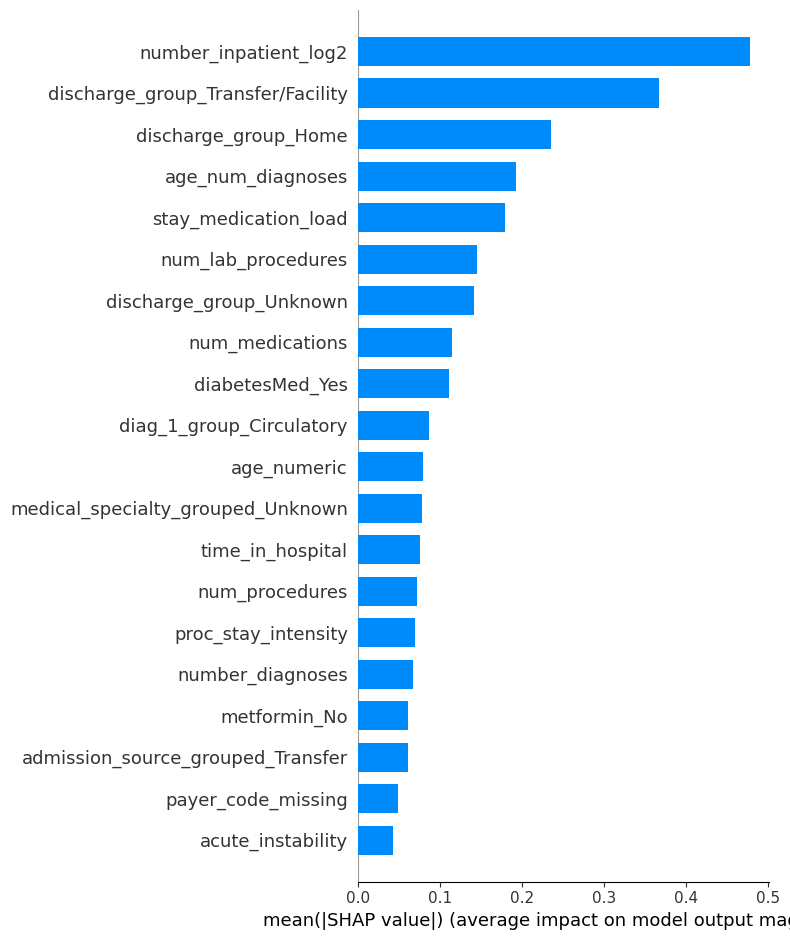

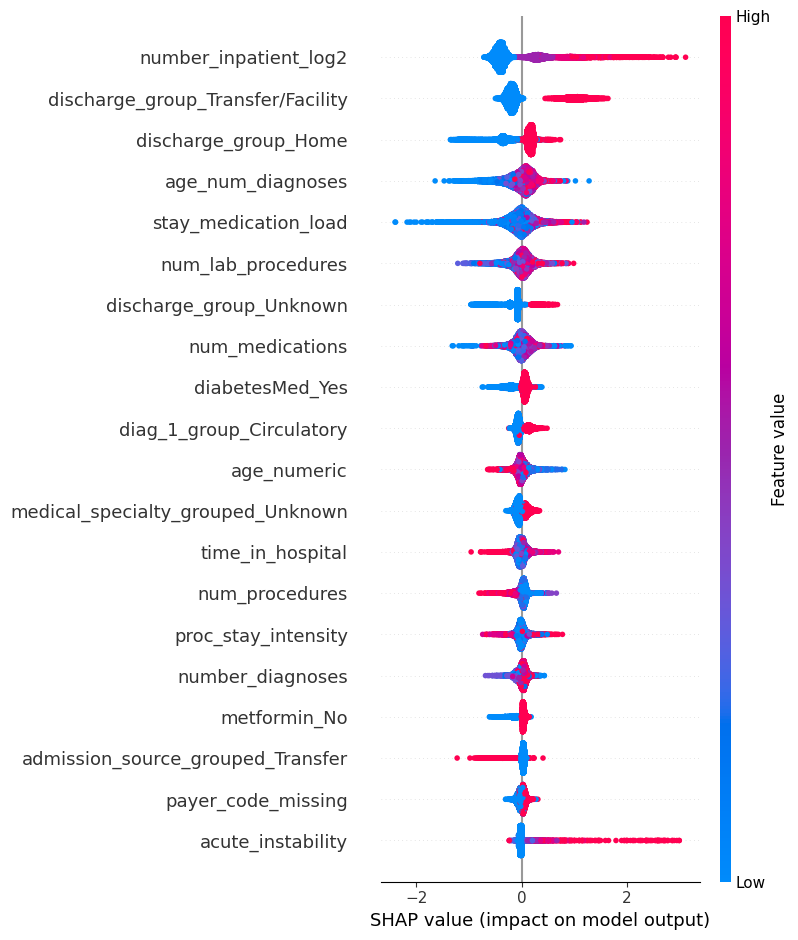

In [ ]:
# SHAP summary plot (bar) - Feature importance
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

# SHAP summary plot (beeswarm) - Impact on predictions
shap.summary_plot(shap_values_xgb, X_test)


**Fitting RUS RF features to use in upcoming models**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define X and y
X = df_filtered.drop('target', axis=1)
y = df_filtered['target']

# 2. Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# 3. Apply RUS
rus = RandomUnderSampler(random_state=1)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)


In [ ]:
# Check columns with object/string types
non_numeric_cols = X_train_rus.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index(['payer_code', 'metformin', 'citoglipton', 'change', 'diabetesMed',
       'admission_type_grouped', 'discharge_group', 'admission_source_grouped',
       'diag_1_group', 'diag_3_group', 'medical_specialty_grouped'],
      dtype='object')


In [ ]:
# Combine train and test to ensure consistent encoding
combined = pd.concat([X_train_rus, X_test], axis=0)

# One-hot encode categorical variables
combined_encoded = pd.get_dummies(combined, columns=[
    'payer_code',
    'metformin',
    'citoglipton',
    'change',
    'diabetesMed',
    'admission_type_grouped',
    'discharge_group',
    'admission_source_grouped',
    'diag_1_group',
    'diag_3_group',
    'medical_specialty_grouped'
], drop_first=True)

# Split back into train and test
X_train_rus_encoded = combined_encoded.iloc[:len(X_train_rus), :]
X_test_encoded = combined_encoded.iloc[len(X_train_rus):, :]


In [ ]:
rf_rus = RandomForestClassifier(n_estimators=200, random_state=1)
rf_rus.fit(X_train_rus_encoded, y_train_rus)

# Predict
y_pred_rf = rf_rus.predict(X_test_encoded)
y_proba_rf = rf_rus.predict_proba(X_test_encoded)[:, 1]


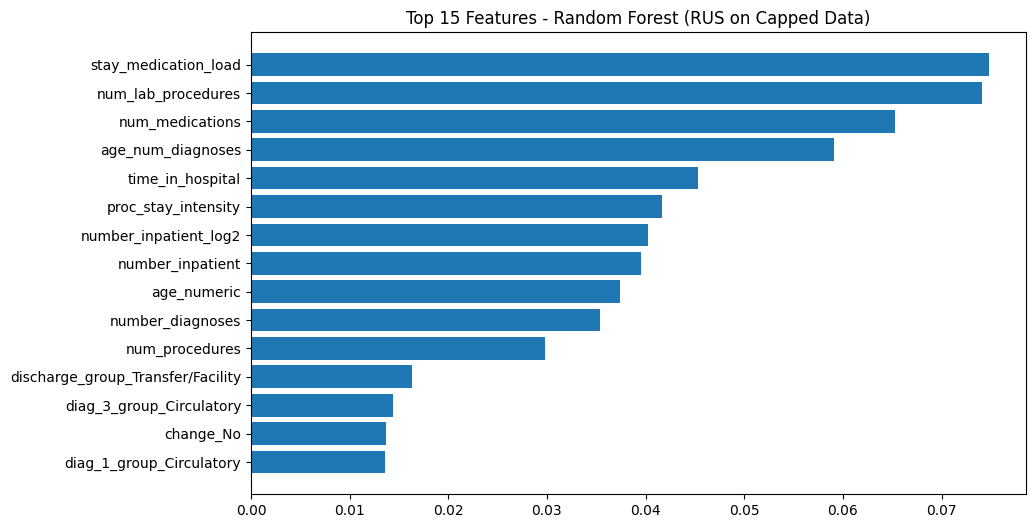

In [ ]:
# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train_rus_encoded.columns,
    'Importance': rf_rus.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 15
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(feature_importances['Feature'][:15], feature_importances['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Features - Random Forest (RUS on Capped Data)")
plt.show()


**Applying Tomek Links**

In [ ]:
# Combine original X_train and X_test for consistent encoding
combined = pd.concat([X_train, X_test], axis=0)

# One-hot encode categorical variables
combined_encoded = pd.get_dummies(combined, columns=[
    'payer_code','metformin','citoglipton','change','diabetesMed',
    'admission_type_grouped','discharge_group','admission_source_grouped',
    'diag_1_group','diag_3_group','medical_specialty_grouped'
], drop_first=True)

# Split back into encoded train and test sets
X_train_encoded = combined_encoded.iloc[:len(X_train), :]
X_test_encoded = combined_encoded.iloc[len(X_train):, :]

In [ ]:
from imblearn.under_sampling import TomekLinks

# Apply Tomek Links on encoded training data
tl = TomekLinks()
X_train_tl, y_train_tl = tl.fit_resample(X_train_encoded, y_train)

print("Tomek Links applied. New training shape:", X_train_tl.shape)


Tomek Links applied. New training shape: (28806, 103)


**Applying SelectKBest**

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 50 features using ANOVA F-test
selector_tl = SelectKBest(score_func=f_classif, k=50)
X_train_tl_sel = selector_tl.fit_transform(X_train_tl, y_train_tl)
X_test_tl_sel = selector_tl.transform(X_test_encoded)

# Get selected features
selected_features_tl = X_train_encoded.columns[selector_tl.get_support()]
print("Selected Features (Tomek Links + KBest):", list(selected_features_tl))


Selected Features (Tomek Links + KBest): ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diag_2_missing', 'diag_3_missing', 'age_numeric', 'stay_medication_load', 'acute_instability', 'age_num_diagnoses', 'number_emergency_log2', 'number_outpatient_log2', 'number_inpatient_log2', 'payer_code_HM', 'payer_code_MC', 'payer_code_UN', 'metformin_No', 'metformin_Steady', 'metformin_Up', 'change_No', 'diabetesMed_Yes', 'admission_type_grouped_Emergency_Urgent', 'discharge_group_Home', 'discharge_group_Hospice', 'discharge_group_Transfer/Facility', 'admission_source_grouped_Referral', 'admission_source_grouped_Transfer', 'diag_1_group_Diabetes', 'diag_1_group_Musculoskeletal', 'diag_1_group_Neoplasms', 'diag_1_group_Other', 'diag_1_group_Other_V', 'diag_1_group_Symptoms', 'diag_3_group_Diabetes', 'diag_3_group_Endocrine_Other', 'diag_3_group_Genitourinary', 'diag_3_group_Respirator

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 8 10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Ensure model_results list exists
if 'model_results' not in globals():
    model_results = []

# 1. Automatically select features covering ~90% cumulative importance
feature_importances['Cumulative_Importance'] = feature_importances['Importance'].cumsum()
selected_features = feature_importances[feature_importances['Cumulative_Importance'] <= 0.90]['Feature'].tolist()

print("Selected features for Logistic Regression:", selected_features)

# 2. Subset train and test to selected features
X_train_log = X_train_rus_encoded[selected_features]
X_test_log = X_test_encoded[selected_features]

# 3. Fit Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=1)
log_reg.fit(X_train_log, y_train_rus)

# 4. Predict
y_pred_log = log_reg.predict(X_test_log)
y_proba_log = log_reg.predict_proba(X_test_log)[:, 1]

# 5. Evaluate metrics
acc = accuracy_score(y_test, y_pred_log)
prec = precision_score(y_test, y_pred_log)
rec = recall_score(y_test, y_pred_log)
f1 = f1_score(y_test, y_pred_log)
roc = roc_auc_score(y_test, y_proba_log)

print("\nLogistic Regression Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")

# 6. Append metrics to model_results
model_results.append({
    'model_type': 'Logistic Regression',
    'balancing_method': 'RUS (Top Features)',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'roc_auc': roc
})

# 7. Show updated model results
results_df = pd.DataFrame(model_results)
print("\nUpdated Model Results:")
display(results_df)


Selected features for Logistic Regression: ['stay_medication_load', 'num_lab_procedures', 'num_medications', 'age_num_diagnoses', 'time_in_hospital', 'proc_stay_intensity', 'number_inpatient_log2', 'number_inpatient', 'age_numeric', 'number_diagnoses', 'num_procedures', 'discharge_group_Transfer/Facility', 'diag_3_group_Circulatory', 'change_No', 'diag_1_group_Circulatory', 'medical_specialty_grouped_Unknown', 'admission_source_grouped_Referral', 'diabetesMed_Yes', 'admission_type_grouped_Emergency_Urgent', 'discharge_group_Home', 'medical_specialty_grouped_General Practice', 'diag_3_group_Diabetes', 'payer_code_Missing', 'payer_code_missing', 'number_outpatient', 'payer_code_MC', 'number_outpatient_log2', 'acute_instability', 'metformin_No', 'medical_specialty_grouped_Medicine Subspecialty', 'metformin_Steady', 'diag_1_group_Respiratory', 'admission_source_grouped_Transfer', 'diag_3_group_Endocrine_Other', 'diag_1_group_Digestive', 'number_emergency', 'diag_3_group_Respiratory', 'diag

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model_type,balancing_method,accuracy,precision,recall,f1_score,roc_auc
0,Decision Tree,Random Undersampling,0.607482,0.264590,0.683560,0.381507,0.687664
1,Decision Tree,Random Oversampling,0.604918,0.261866,0.676746,0.377614,0.688029
2,Decision Tree,SMOTE,0.747021,0.242051,0.201022,0.219637,0.627170
3,Decision Tree (Tuned),Random Oversampling,0.737970,0.273714,0.290034,0.281638,0.562203
4,Random Forest,Random Undersampling,0.661940,0.289961,0.627342,0.396607,0.710260
5,Random Forest,Random Oversampling,0.825916,0.538760,0.118399,0.194134,0.705123
6,Random Forest,SMOTE,0.822371,0.490141,0.074106,0.128746,0.671531
7,Balanced Random Forest,Internal Balanced RF,0.760447,0.358607,0.447189,0.398029,0.709461
8,SMOTE + AdaBoost,<class 'imblearn.over_sampling._smote.base.SMO...,0.737970,0.273714,0.290034,0.283574,0.562203
9,Logistic Regression,RUS (Top Features),0.680872,0.298868,0.595826,0.398065,0.705541


**Apply Tomek Links**

In [ ]:
from imblearn.under_sampling import TomekLinks

# Apply Tomek Links on encoded training data
tl = TomekLinks()
X_train_tl, y_train_tl = tl.fit_resample(X_train_encoded, y_train)

print("Tomek Links applied. New training shape:", X_train_tl.shape)


Tomek Links applied. New training shape: (28806, 103)


**Apply SelectKBest**

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 50 features using ANOVA F-test
selector_tl = SelectKBest(score_func=f_classif, k=50)
X_train_tl_sel = selector_tl.fit_transform(X_train_tl, y_train_tl)
X_test_tl_sel = selector_tl.transform(X_test_encoded)

# Get selected features
selected_features_tl = X_train_encoded.columns[selector_tl.get_support()]
print("Selected Features (Tomek Links + KBest):", list(selected_features_tl))


Selected Features (Tomek Links + KBest): ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diag_2_missing', 'diag_3_missing', 'age_numeric', 'stay_medication_load', 'acute_instability', 'age_num_diagnoses', 'number_emergency_log2', 'number_outpatient_log2', 'number_inpatient_log2', 'payer_code_HM', 'payer_code_MC', 'payer_code_UN', 'metformin_No', 'metformin_Steady', 'metformin_Up', 'change_No', 'diabetesMed_Yes', 'admission_type_grouped_Emergency_Urgent', 'discharge_group_Home', 'discharge_group_Hospice', 'discharge_group_Transfer/Facility', 'admission_source_grouped_Referral', 'admission_source_grouped_Transfer', 'diag_1_group_Diabetes', 'diag_1_group_Musculoskeletal', 'diag_1_group_Neoplasms', 'diag_1_group_Other', 'diag_1_group_Other_V', 'diag_1_group_Symptoms', 'diag_3_group_Diabetes', 'diag_3_group_Endocrine_Other', 'diag_3_group_Genitourinary', 'diag_3_group_Respirator

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 8 10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


**Logistic Regression on Tomek Links + KBest**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Fit Logistic Regression
log_reg_tl = LogisticRegression(max_iter=1000, random_state=1)
log_reg_tl.fit(X_train_tl_sel, y_train_tl)

# Predict
y_pred_tl = log_reg_tl.predict(X_test_tl_sel)
y_proba_tl = log_reg_tl.predict_proba(X_test_tl_sel)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_tl)
prec = precision_score(y_test, y_pred_tl)
rec = recall_score(y_test, y_pred_tl)
f1 = f1_score(y_test, y_pred_tl)
roc = roc_auc_score(y_test, y_proba_tl)

print("\nLogistic Regression (Tomek Links + KBest) Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")

# Append metrics
model_results.append({
    'model_type': 'Logistic Regression',
    'balancing_method': 'Tomek Links + KBest',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'roc_auc': roc
})



Logistic Regression (Tomek Links + KBest) Performance:
Accuracy: 0.8257
Precision: 0.5383
Recall: 0.1107
F1 Score: 0.1837
ROC AUC: 0.6976


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Apply SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE on encoded training data
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)

print("SMOTE applied. New training shape:", X_train_smote.shape)


SMOTE applied. New training shape: (50916, 103)


**Apply SelectKBest**

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 50 features using ANOVA F-test
selector_smote = SelectKBest(score_func=f_classif, k=50)
X_train_smote_sel = selector_smote.fit_transform(X_train_smote, y_train_smote)
X_test_smote_sel = selector_smote.transform(X_test_encoded)

# Get selected features
selected_features_smote = X_train_encoded.columns[selector_smote.get_support()]
print("Selected Features (SMOTE + KBest):", list(selected_features_smote))


Selected Features (SMOTE + KBest): ['num_procedures', 'num_medications', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'payer_code_missing', 'diag_3_missing', 'stay_medication_load', 'acute_instability', 'age_num_diagnoses', 'number_emergency_log2', 'number_outpatient_log2', 'number_inpatient_log2', 'payer_code_MC', 'payer_code_MD', 'payer_code_Missing', 'payer_code_SP', 'metformin_No', 'metformin_Steady', 'change_No', 'diabetesMed_Yes', 'admission_type_grouped_Emergency_Urgent', 'admission_type_grouped_Unknown', 'discharge_group_Home', 'discharge_group_Transfer/Facility', 'discharge_group_Unknown', 'admission_source_grouped_Others', 'admission_source_grouped_Referral', 'diag_1_group_Circulatory', 'diag_1_group_Diabetes', 'diag_1_group_Digestive', 'diag_1_group_Genitourinary', 'diag_1_group_Injury', 'diag_1_group_Mental_Disorders', 'diag_1_group_Other_V', 'diag_1_group_Respiratory', 'diag_3_group_Circulatory', 'diag_3_group_Diabetes', 'diag_3_group_Digestive', 'diag_3_gro

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 8 10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


**SMOTE + SelectKBest**

In [ ]:
# Fit Logistic Regression
log_reg_smote = LogisticRegression(max_iter=1000, random_state=1)
log_reg_smote.fit(X_train_smote_sel, y_train_smote)

# Predict
y_pred_smote = log_reg_smote.predict(X_test_smote_sel)
y_proba_smote = log_reg_smote.predict_proba(X_test_smote_sel)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_smote)
prec = precision_score(y_test, y_pred_smote)
rec = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)
roc = roc_auc_score(y_test, y_proba_smote)

print("\nLogistic Regression (SMOTE + KBest) Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")

# Append metrics
model_results.append({
    'model_type': 'Logistic Regression',
    'balancing_method': 'SMOTE + KBest',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'roc_auc': roc
})



Logistic Regression (SMOTE + KBest) Performance:
Accuracy: 0.8062
Precision: 0.4009
Recall: 0.1904
F1 Score: 0.2582
ROC AUC: 0.6641


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Apply ROS**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Apply ROS on encoded training data
ros = RandomOverSampler(random_state=1)
X_train_ros, y_train_ros = ros.fit_resample(X_train_encoded, y_train)

print("ROS applied. New training shape:", X_train_ros.shape)


ROS applied. New training shape: (50916, 103)


**Apply Select KBEST**

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 50 features using ANOVA F-test
selector_ros = SelectKBest(score_func=f_classif, k=50)
X_train_ros_sel = selector_ros.fit_transform(X_train_ros, y_train_ros)
X_test_ros_sel = selector_ros.transform(X_test_encoded)

# Get selected features
selected_features_ros = X_train_encoded.columns[selector_ros.get_support()]
print("Selected Features (ROS + KBest):", list(selected_features_ros))


Selected Features (ROS + KBest): ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diag_2_missing', 'diag_3_missing', 'age_numeric', 'stay_medication_load', 'acute_instability', 'age_num_diagnoses', 'number_emergency_log2', 'number_outpatient_log2', 'number_inpatient_log2', 'payer_code_CM', 'payer_code_HM', 'payer_code_MC', 'payer_code_UN', 'payer_code_WC', 'metformin_No', 'metformin_Steady', 'change_No', 'diabetesMed_Yes', 'admission_type_grouped_Emergency_Urgent', 'discharge_group_Home', 'discharge_group_Hospice', 'discharge_group_Transfer/Facility', 'admission_source_grouped_Referral', 'admission_source_grouped_Transfer', 'diag_1_group_Diabetes', 'diag_1_group_Musculoskeletal', 'diag_1_group_Neoplasms', 'diag_1_group_Other', 'diag_1_group_Other_V', 'diag_1_group_Symptoms', 'diag_3_group_Endocrine_Other', 'diag_3_group_Genitourinary', 'diag_3_group_Respiratory', 'diag_3_gro

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 8 10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


**Random Oversampling + SelectKBest**

In [ ]:
# Fit Logistic Regression
log_reg_ros = LogisticRegression(max_iter=2000, random_state=1)
log_reg_ros.fit(X_train_ros_sel, y_train_ros)

# Predict
y_pred_ros = log_reg_ros.predict(X_test_ros_sel)
y_proba_ros = log_reg_ros.predict_proba(X_test_ros_sel)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_ros)
prec = precision_score(y_test, y_pred_ros)
rec = recall_score(y_test, y_pred_ros)
f1 = f1_score(y_test, y_pred_ros)
roc = roc_auc_score(y_test, y_proba_ros)

print("\nLogistic Regression (ROS + KBest) Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")

# Append metrics
model_results.append({
    'model_type': 'Logistic Regression',
    'balancing_method': 'ROS + KBest',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'roc_auc': roc
})



Logistic Regression (ROS + KBest) Performance:
Accuracy: 0.6825
Precision: 0.2981
Recall: 0.5852
F1 Score: 0.3950
ROC AUC: 0.7036


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Apply RUS**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Apply RUS on encoded training data
rus = RandomUnderSampler(random_state=1)
X_train_rus_final, y_train_rus_final = rus.fit_resample(X_train_encoded, y_train)

print("RUS applied. New training shape:", X_train_rus_final.shape)


RUS applied. New training shape: (10954, 103)


**Apply SelectKBest**

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top 50 features using ANOVA F-test
selector_rus = SelectKBest(score_func=f_classif, k=50)
X_train_rus_sel = selector_rus.fit_transform(X_train_rus_final, y_train_rus_final)
X_test_rus_sel = selector_rus.transform(X_test_encoded)

# Get selected features
selected_features_rus = X_train_encoded.columns[selector_rus.get_support()]
print("Selected Features (RUS + KBest):", list(selected_features_rus))


Selected Features (RUS + KBest): ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diag_3_missing', 'age_numeric', 'stay_medication_load', 'acute_instability', 'age_num_diagnoses', 'proc_stay_intensity', 'number_emergency_log2', 'number_outpatient_log2', 'number_inpatient_log2', 'payer_code_CP', 'payer_code_HM', 'payer_code_MC', 'payer_code_MD', 'payer_code_UN', 'payer_code_WC', 'metformin_No', 'metformin_Steady', 'change_No', 'diabetesMed_Yes', 'discharge_group_Home', 'discharge_group_Hospice', 'discharge_group_Transfer/Facility', 'admission_source_grouped_Referral', 'admission_source_grouped_Transfer', 'diag_1_group_Circulatory', 'diag_1_group_Diabetes', 'diag_1_group_Digestive', 'diag_1_group_Musculoskeletal', 'diag_1_group_Neoplasms', 'diag_1_group_Other_V', 'diag_1_group_Symptoms', 'diag_3_group_Diabetes', 'diag_3_group_Genitourinary', 'diag_3_group_Unknown', 'medical_sp

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 8 10 29 53 89] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


**Random Undersampling + SelectKBest**

In [ ]:
# Fit Logistic Regression
log_reg_rus = LogisticRegression(max_iter=1000, random_state=1)
log_reg_rus.fit(X_train_rus_sel, y_train_rus_final)

# Predict
y_pred_rus = log_reg_rus.predict(X_test_rus_sel)
y_proba_rus = log_reg_rus.predict_proba(X_test_rus_sel)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_rus)
prec = precision_score(y_test, y_pred_rus)
rec = recall_score(y_test, y_pred_rus)
f1 = f1_score(y_test, y_pred_rus)
roc = roc_auc_score(y_test, y_proba_rus)

print("\nLogistic Regression (RUS + KBest) Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")

# Append metrics
model_results.append({
    'model_type': 'Logistic Regression',
    'balancing_method': 'RUS + KBest',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'roc_auc': roc
})



Logistic Regression (RUS + KBest) Performance:
Accuracy: 0.6809
Precision: 0.2968
Recall: 0.5856
F1 Score: 0.3940
ROC AUC: 0.7040


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Full Smote**

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE on encoded training data
smote_full = SMOTE(random_state=1)
X_train_smote_full, y_train_smote_full = smote_full.fit_resample(X_train_encoded, y_train)

print("Full SMOTE applied. New training shape:", X_train_smote_full.shape)


Full SMOTE applied. New training shape: (50916, 103)


In [ ]:
# Fit Logistic Regression
log_reg_smote_full = LogisticRegression(max_iter=2000, random_state=1)
log_reg_smote_full.fit(X_train_smote_full, y_train_smote_full)

# Predict
y_pred_smote_full = log_reg_smote_full.predict(X_test_encoded)
y_proba_smote_full = log_reg_smote_full.predict_proba(X_test_encoded)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_smote_full)
prec = precision_score(y_test, y_pred_smote_full)
rec = recall_score(y_test, y_pred_smote_full)
f1 = f1_score(y_test, y_pred_smote_full)
roc = roc_auc_score(y_test, y_proba_smote_full)

print("\nLogistic Regression (Full SMOTE) Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")

# Append metrics
model_results.append({
    'model_type': 'Logistic Regression',
    'balancing_method': 'Full SMOTE',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'roc_auc': roc
})



Logistic Regression (Full SMOTE) Performance:
Accuracy: 0.8212
Precision: 0.4808
Recall: 0.1175
F1 Score: 0.1889
ROC AUC: 0.6753


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Logistic Regression on RUS**

In [ ]:
# Apply RUS (Random Undersampling)
rus = RandomUnderSampler(random_state=1)
X_train_rus_only, y_train_rus_only = rus.fit_resample(X_train_encoded, y_train)

# Fit Logistic Regression
log_reg_rus_only = LogisticRegression(max_iter=1000, random_state=1)
log_reg_rus_only.fit(X_train_rus_only, y_train_rus_only)

# Predict
y_pred_rus_only = log_reg_rus_only.predict(X_test_encoded)
y_proba_rus_only = log_reg_rus_only.predict_proba(X_test_encoded)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_rus_only)
prec = precision_score(y_test, y_pred_rus_only)
rec = recall_score(y_test, y_pred_rus_only)
f1 = f1_score(y_test, y_pred_rus_only)
roc = roc_auc_score(y_test, y_proba_rus_only)

print("\nLogistic Regression (RUS Only) Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")

# Append metrics
model_results.append({
    'model_type': 'Logistic Regression',
    'balancing_method': 'RUS (No KBest)',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'roc_auc': roc
})



Logistic Regression (RUS Only) Performance:
Accuracy: 0.6788
Precision: 0.2972
Recall: 0.5963
F1 Score: 0.3967
ROC AUC: 0.7046


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Logistic Regression on ROS**

In [ ]:
# Apply ROS (Random Oversampling)
ros = RandomOverSampler(random_state=1)
X_train_ros_only, y_train_ros_only = ros.fit_resample(X_train_encoded, y_train)

# Fit Logistic Regression
log_reg_ros_only = LogisticRegression(max_iter=5000, random_state=1)
log_reg_ros_only.fit(X_train_ros_only, y_train_ros_only)

# Predict
y_pred_ros_only = log_reg_ros_only.predict(X_test_encoded)
y_proba_ros_only = log_reg_ros_only.predict_proba(X_test_encoded)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred_ros_only)
prec = precision_score(y_test, y_pred_ros_only)
rec = recall_score(y_test, y_pred_ros_only)
f1 = f1_score(y_test, y_pred_ros_only)
roc = roc_auc_score(y_test, y_proba_ros_only)

print("\nLogistic Regression (ROS Only) Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")

# Append metrics
model_results.append({
    'model_type': 'Logistic Regression',
    'balancing_method': 'ROS (No KBest)',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'roc_auc': roc
})



Logistic Regression (ROS Only) Performance:
Accuracy: 0.6839
Precision: 0.3025
Recall: 0.6009
F1 Score: 0.4024
ROC AUC: 0.7175


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import pandas as pd

# Convert model_results to DataFrame
results_df = pd.DataFrame(model_results)

# Sort by Recall first, then ROC AUC
results_sorted = results_df.sort_values(by=['recall', 'roc_auc'], ascending=[False, False])

print("\nFinal Model Metrics (Sorted by Recall & ROC AUC):")
display(results_sorted.reset_index(drop=True))



Final Model Metrics (Sorted by Recall & ROC AUC):


,model_type,balancing_method,accuracy,precision,recall,f1_score,roc_auc
0,Decision Tree,Random Undersampling,0.607482,0.264590,0.683560,0.381507,0.687664
1,Decision Tree,Random Oversampling,0.604918,0.261866,0.676746,0.377614,0.688029
2,Neural Network (Final Config),ROS + SelectKBest,0.629733,0.275784,0.670784,0.390867,0.705786
3,Neural Network (K-Fold Tuned),ROS + SelectKBest,0.622115,0.265916,0.643952,0.376400,0.692355
4,XGBoost,RUS,0.641877,0.277117,0.635434,0.385929,0.697692
5,Random Forest,Random Undersampling,0.661940,0.289961,0.627342,0.396607,0.710260
6,Logistic Regression,ROS (No KBest),0.683889,0.302465,0.600937,0.402396,0.717483
7,Logistic Regression,ROS (No KBest),0.683889,0.302465,0.600937,0.402396,0.717483
8,Logistic Regression,RUS (No KBest),0.678760,0.297177,0.596252,0.396657,0.704629
9,Logistic Regression,RUS (No KBest),0.678760,0.297177,0.596252,0.396657,0.704629


Logistic Reression with both Random undersampling and Random
Oversampling provides similar metrics, I will be proceeding with Oversampling to retain all original data

In [ ]:
import numpy as np
import pandas as pd

# Extract coefficients
odds_ratios = np.exp(log_reg_ros_only.coef_[0])

# Create DataFrame
odds_df = pd.DataFrame({
    "Feature": X_train_ros_only.columns,
    "Odds_Ratio": odds_ratios,
    "Coefficient": log_reg_ros_only.coef_[0]
}).sort_values(by="Odds_Ratio", ascending=False)

print("Top 15 Features by Odds Ratio:")
display(odds_df.head(15))

print("\nLowest 15 Features by Odds Ratio:")
display(odds_df.tail(15))


Top 15 Features by Odds Ratio:


,Feature,Odds_Ratio,Coefficient
51,discharge_group_Transfer/Facility,21.727807,3.078593
46,discharge_group_Home,12.600520,2.533738
52,discharge_group_Unknown,12.157277,2.497928
48,discharge_group_Left AMA,10.707855,2.370978
47,discharge_group_Hospice,2.153781,0.767225
50,discharge_group_Outpatient Followup,1.701346,0.531420
21,number_inpatient_log2,1.588434,0.462749
22,payer_code_CH,1.543762,0.434222
23,payer_code_CM,1.522677,0.420470
42,diabetesMed_Yes,1.303966,0.265410



Lowest 15 Features by Odds Ratio:


,Feature,Odds_Ratio,Coefficient
54,admission_source_grouped_Others,0.730369,-0.314205
78,diag_3_group_Infectious,0.730331,-0.314258
71,diag_1_group_Symptoms,0.707269,-0.346345
33,payer_code_PO,0.694764,-0.364184
98,medical_specialty_grouped_Psychiatry/Psychology,0.692606,-0.367294
62,diag_1_group_Infectious,0.690197,-0.370778
101,medical_specialty_grouped_Surgery,0.685251,-0.377970
56,admission_source_grouped_Transfer,0.650851,-0.429475
96,medical_specialty_grouped_Other,0.650845,-0.429483
39,metformin_Steady,0.635746,-0.452956


# Neural Network

In [ ]:
from sklearn.model_selection import train_test_split

X = df_filtered.drop('target', axis=1)
y = df_filtered['target']

# Split 70/30
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (30935, 33) Test: (13258, 33)


In [ ]:
# Combine train + test for consistent encoding
combined = pd.concat([X_train, X_test], axis=0)
combined_encoded = pd.get_dummies(combined, drop_first=True)

# Split back into encoded train/test
X_train_encoded = combined_encoded.iloc[:len(X_train), :]
X_test_encoded = combined_encoded.iloc[len(X_train):, :]
print("Encoded shapes:", X_train_encoded.shape, X_test_encoded.shape)


Encoded shapes: (30935, 103) (13258, 103)


In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
X_ros, y_ros = ros.fit_resample(X_train_encoded, y_train)
print("ROS-balanced:", X_ros.shape, y_ros.shape)


ROS-balanced: (50916, 103) (50916,)


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector_ros = SelectKBest(score_func=f_classif, k=50)
X_train_ros_sel = selector_ros.fit_transform(X_ros, y_ros)
X_test_ros_sel = selector_ros.transform(X_test_encoded)
print("ROS + KBest:", X_train_ros_sel.shape, X_test_ros_sel.shape)


ROS + KBest: (50916, 50) (13258, 50)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 8 10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train_ros_sel, y_ros, test_size=0.3, stratify=y_ros, random_state=1
)
print("NN Train:", X_train_nn.shape, "NN Validation:", X_val_nn.shape)


NN Train: (35641, 50) NN Validation: (15275, 50)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

final_nn = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_ros_sel.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

final_nn.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history = final_nn.fit(
    X_train_ros_sel, y_ros,
    epochs=30,
    batch_size=64,
    validation_data=(X_test_ros_sel, y_test),
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.5126 - loss: 4.7180 - val_accuracy: 0.6180 - val_loss: 0.6872
Epoch 2/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5135 - loss: 0.7212 - val_accuracy: 0.5892 - val_loss: 0.6878
Epoch 3/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5130 - loss: 0.7014 - val_accuracy: 0.6668 - val_loss: 0.6857
Epoch 4/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5143 - loss: 0.6967 - val_accuracy: 0.8229 - val_loss: 0.6692
Epoch 5/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5191 - loss: 0.6927 - val_accuracy: 0.5108 - val_loss: 0.6952
Epoch 6/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5204 - loss: 0.6931 - val_accuracy: 0.4261 - val_loss: 0.7152
Epoch 7/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5410 - loss: 0.6895 - val_accuracy: 0.7203 - val_loss: 0.6645
Epoch 8/30
796/796 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5649 - loss: 0.6816 - val_accuracy: 0

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predictions
y_pred_final = (final_nn.predict(X_test_ros_sel) >= 0.5).astype(int)
y_proba_final = final_nn.predict(X_test_ros_sel)

# Metrics
acc = accuracy_score(y_test, y_pred_final)
prec = precision_score(y_test, y_pred_final)
rec = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
roc = roc_auc_score(y_test, y_proba_final)

print("\n🎯 Final NN Performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")

model_results.append({
    'model_type': 'Neural Network (Final Config)',
    'balancing_method': 'ROS + SelectKBest',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'roc_auc': roc
})


415/415 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

🎯 Final NN Performance:
Accuracy:  0.6297
Precision: 0.2758
Recall:    0.6708
F1 Score:  0.3909
ROC AUC:   0.7058


In [ ]:
import pandas as pd
results_df = pd.DataFrame(model_results)
print("\n Updated Model Results:")
display(results_df)


 Updated Model Results:


,model_type,balancing_method,accuracy,precision,recall,f1_score,roc_auc
0,Decision Tree,Random Undersampling,0.607482,0.264590,0.683560,0.381507,0.687664
1,Decision Tree,Random Oversampling,0.604918,0.261866,0.676746,0.377614,0.688029
2,Decision Tree,SMOTE,0.747021,0.242051,0.201022,0.219637,0.627170
3,Decision Tree (Tuned),Random Oversampling,0.737970,0.273714,0.290034,0.281638,0.562203
4,Random Forest,Random Undersampling,0.661940,0.289961,0.627342,0.396607,0.710260
5,Random Forest,Random Oversampling,0.825916,0.538760,0.118399,0.194134,0.705123
6,Random Forest,SMOTE,0.822371,0.490141,0.074106,0.128746,0.671531
7,Balanced Random Forest,Internal Balanced RF,0.760447,0.358607,0.447189,0.398029,0.709461
8,SMOTE + AdaBoost,<class 'imblearn.over_sampling._smote.base.SMO...,0.737970,0.273714,0.290034,0.283574,0.562203
9,XGBoost,scale_pos_weight,0.711420,0.312911,0.526405,0.392506,0.698592


**Hypertuning**

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Parameter grid for randomized trials
param_grid = {
    'units1': [32, 64],
    'units2': [16, 32],
    'dropout': [0.2, 0.3],
    'lr': [0.0005, 0.001],
    'batch_size': [32, 64],
    'epochs': [25, 30]
}

def build_nn(units1, units2, dropout, lr):
    model = Sequential([
        Dense(units1, activation='relu', input_shape=(X_train_ros_sel.shape[1],)),
        Dropout(dropout),
        Dense(units2, activation='relu'),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Cross-validation setup
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

best_recall = 0
best_params = None
best_model = None

for i in range(5):  # Random trials
    params = {k: np.random.choice(v) for k, v in param_grid.items()}
    print(f"\n Trial {i+1}: {params}")

    fold_recalls, fold_precisions = [], []

    for train_idx, val_idx in kf.split(X_train_ros_sel, y_ros):
        X_tr, X_val = X_train_ros_sel[train_idx], X_train_ros_sel[val_idx]
        y_tr, y_val = y_ros.iloc[train_idx], y_ros.iloc[val_idx]

        model = build_nn(params['units1'], params['units2'], params['dropout'], params['lr'])
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        model.fit(X_tr, y_tr,
                  validation_data=(X_val, y_val),
                  epochs=params['epochs'],
                  batch_size=params['batch_size'],
                  verbose=0,
                  callbacks=[early_stop])

        y_val_pred = (model.predict(X_val) >= 0.5).astype(int)
        recall = recall_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred)

        fold_recalls.append(recall)
        fold_precisions.append(precision)

    avg_recall = np.mean(fold_recalls)
    avg_precision = np.mean(fold_precisions)
    print(f"Avg Recall: {avg_recall:.4f}, Avg Precision: {avg_precision:.4f}")

    # Only accept if recall is good but precision is not too low
    if avg_recall > best_recall and avg_precision > 0.2:
        best_recall = avg_recall
        best_params = params
        best_model = model

print("\n Best Params:", best_params)
print(" Best Validation Recall:", best_recall)



 Trial 1: {'units1': np.int64(32), 'units2': np.int64(16), 'dropout': np.float64(0.3), 'lr': np.float64(0.001), 'batch_size': np.int64(32), 'epochs': np.int64(25)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Avg Recall: 0.5662, Avg Precision: 0.6761

 Trial 2: {'units1': np.int64(32), 'units2': np.int64(16), 'dropout': np.float64(0.2), 'lr': np.float64(0.0005), 'batch_size': np.int64(64), 'epochs': np.int64(30)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Avg Recall: 0.5648, Avg Precision: 0.6761

 Trial 3: {'units1': np.int64(32), 'units2': np.int64(16), 'dropout': np.float64(0.3), 'lr': np.float64(0.001), 'batch_size': np.int64(64), 'epochs': np.int64(30)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Avg Recall: 0.6566, Avg Precision: 0.6452

 Trial 4: {'units1': np.int64(32), 'units2': np.int64(16), 'dropout': np.float64(0.2), 'lr': np.float64(0.0005), 'batch_size': np.int64(64), 'epochs': np.int64(25)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Avg Recall: 0.6158, Avg Precision: 0.6531

 Trial 5: {'units1': np.int64(64), 'units2': np.int64(32), 'dropout': np.float64(0.3), 'lr': np.float64(0.001), 'batch_size': np.int64(64), 'epochs': np.int64(25)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Avg Recall: 0.5671, Avg Precision: 0.6784

 Best Params: {'units1': np.int64(32), 'units2': np.int64(16), 'dropout': np.float64(0.3), 'lr': np.float64(0.001), 'batch_size': np.int64(64), 'epochs': np.int64(30)}
 Best Validation Recall: 0.6565716081388954


In [ ]:
y_pred_best = (best_model.predict(X_test_ros_sel) >= 0.5).astype(int)
y_proba_best = best_model.predict(X_test_ros_sel)

acc = accuracy_score(y_test, y_pred_best)
prec = precision_score(y_test, y_pred_best)
rec = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)
roc = roc_auc_score(y_test, y_proba_best)

print("\n NN Test Performance (K-Fold Tuned):")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc:.4f}")

model_results.append({
    'model_type': 'Neural Network (K-Fold Tuned)',
    'balancing_method': 'ROS + SelectKBest',
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'roc_auc': roc
})


415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
415/415 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

 NN Test Performance (K-Fold Tuned):
Accuracy:  0.6221
Precision: 0.2659
Recall:    0.6440
F1 Score:  0.3764
ROC AUC:   0.6924


# Final Metrics

In [ ]:
results_df = pd.DataFrame(model_results)
print("\n Updated Model Results:")
display(results_df)


 Updated Model Results:


,model_type,balancing_method,accuracy,precision,recall,f1_score,roc_auc
0,Decision Tree,Random Undersampling,0.607482,0.264590,0.683560,0.381507,0.687664
1,Decision Tree,Random Oversampling,0.604918,0.261866,0.676746,0.377614,0.688029
2,Decision Tree,SMOTE,0.747021,0.242051,0.201022,0.219637,0.627170
3,Decision Tree (Tuned),Random Oversampling,0.737970,0.273714,0.290034,0.281638,0.562203
4,Random Forest,Random Undersampling,0.661940,0.289961,0.627342,0.396607,0.710260
5,Random Forest,Random Oversampling,0.825916,0.538760,0.118399,0.194134,0.705123
6,Random Forest,SMOTE,0.822371,0.490141,0.074106,0.128746,0.671531
7,Balanced Random Forest,Internal Balanced RF,0.760447,0.358607,0.447189,0.398029,0.709461
8,SMOTE + AdaBoost,<class 'imblearn.over_sampling._smote.base.SMO...,0.737970,0.273714,0.290034,0.283574,0.562203
9,XGBoost,scale_pos_weight,0.711420,0.312911,0.526405,0.392506,0.698592


**Decision Tree with Random Undersampling remains my top performing Model with 68.35% of Recall and 68.766 of AUC, While Neural Network stands my second best model with 67% of Recall and 70% of AUC**

In [ ]:
!pip install shap
import shap
import numpy as np
import pandas as pd


In [ ]:
# Get feature names from SelectKBest
feature_names = selector_ros.get_feature_names_out()

# Convert to DataFrame for SHAP
X_test_shap = pd.DataFrame(X_test_ros_sel, columns=feature_names)


In [ ]:
# Use a small background sample for SHAP to speed up computation
background = X_test_shap.sample(50, random_state=1)

# Define explainer using KernelExplainer
explainer = shap.KernelExplainer(
    lambda x: final_nn.predict(x).flatten(),
    background
)

# Compute SHAP values (on subset for speed)
shap_values = explainer.shap_values(X_test_shap.iloc[:200], nsamples=100)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
157/157 ━

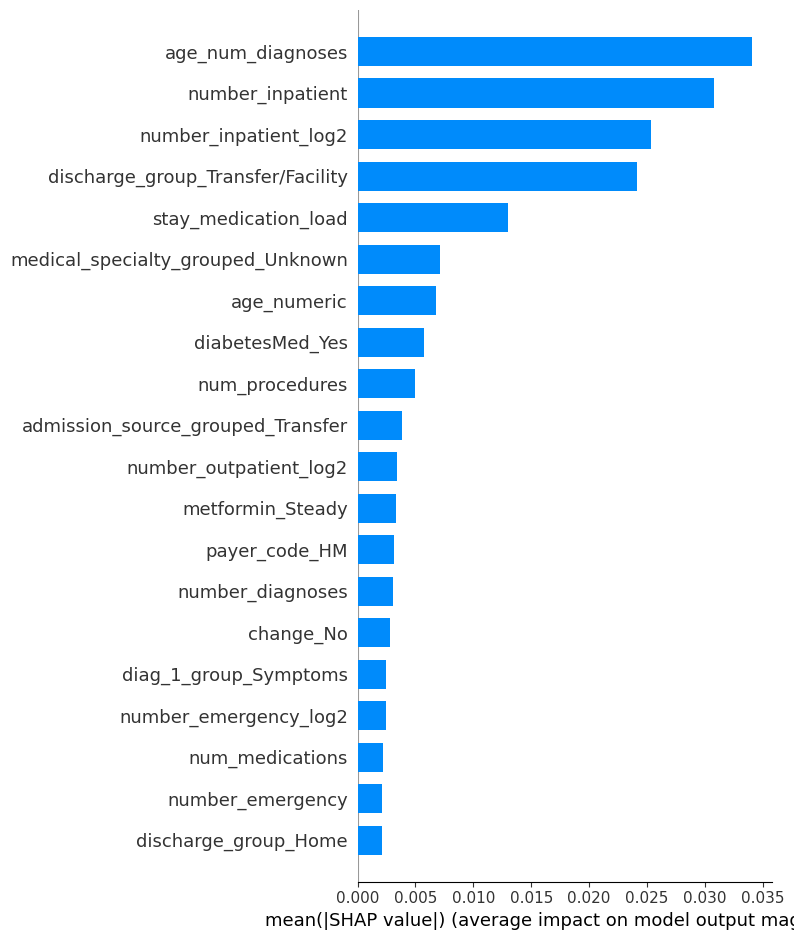

In [ ]:
shap.summary_plot(shap_values, X_test_shap, plot_type="bar")
